<a href="https://colab.research.google.com/github/Lu-David/CovariateShift/blob/main/Covariate_Shift_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch implementation of 2014 Liu Paper

https://proceedings.neurips.cc/paper/2014/file/d67d8ab4f4c10bf22aa353e27879133c-Paper.pdf

## Binary Classification

### Load Data

In [ ]:
import scipy.io
import numpy as np
import os
import torch

folder_path = '../matlab/CovariateShift/data/gaussian' # TODO Upload data files and / or specify path

x_1 = scipy.io.loadmat(os.path.join(folder_path, 'x_1.mat'))['x_1']
x_2 = scipy.io.loadmat(os.path.join(folder_path, 'x_2.mat'))['x_2']
y_1 = np.transpose(scipy.io.loadmat(os.path.join(folder_path, 'y_1.mat'))['y_1'])
y_2 = np.transpose(scipy.io.loadmat(os.path.join(folder_path, 'y_2.mat'))['y_2'])

n_row, n_col = x_1.shape

x_1 = torch.FloatTensor(x_1)
x_2 = torch.FloatTensor(x_2)
x_1_b = torch.cat((torch.ones((n_row, 1)), torch.FloatTensor(x_1)), dim = 1)
x_2_b = torch.cat((torch.ones((n_row, 1)), torch.FloatTensor(x_2)), dim = 1)
y_1 = torch.FloatTensor(y_1)
y_2 = torch.FloatTensor(y_2)

In [ ]:
# source mean 
mu_s = [6, 6] 

# source variance
var_s = [[3, -2], [-2, 3]] 

# target mean
mu_t = [7, 7] 

# target variance
var_t = [[3, 2], [2, 3]] 

In [ ]:
from scipy.stats import multivariate_normal

mvn_s = multivariate_normal(mu_s, var_s)
mvn_t = multivariate_normal(mu_t, var_t)

# Because we have expert knowledge on mu and var for both source and target, 
# we can get the predicted probabilities for each data point under source and target distributions 
d_s = mvn_s.pdf(x_1)
d_t = mvn_t.pdf(x_1)

In [ ]:
x_1_sec = torch.cat((x_1, (x_1[:, 0] ** 2).unsqueeze(1), (x_1[:, 0] * x_1[:, 1]).unsqueeze(1), (x_1[:, 1] ** 2).unsqueeze(1)), dim =1)
x_2_sec = torch.cat((x_2, (x_2[:, 0] ** 2).unsqueeze(1), (x_2[:, 0] * x_2[:, 1]).unsqueeze(1), (x_2[:, 1] ** 2).unsqueeze(1)), dim =1)

In [ ]:
x_1_sec_b = torch.cat((torch.ones((n_row, 1)), x_1_sec), dim =1)
x_2_sec_b = torch.cat((torch.ones((n_row, 1)), x_2_sec), dim =1)

### Logistic Regression (LR) + Importance Weighting (IW)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam

class LRClassifier(nn.Module):
    def __init__(self, in_features = 2, out_features = 1):
      super(LRClassifier, self).__init__()
      
      self.layer1 = nn.Linear(in_features, out_features, bias = False)
      self.activation1 = nn.Sigmoid()

    def forward(self, input):
      return self.activation1(self.layer1(input))

In [ ]:
def binaryLRTrain(X_s, y_s, r_ts, max_itr = 10000, lr = 0.01, weight_decay = 0):

  n_row, n_col = X_s.shape

  lr_model = LRClassifier(in_features = n_col)
  loss_fn = nn.BCELoss() 
  optimizer = torch.optim.Adam(lr_model.parameters(), lr = lr, weight_decay = weight_decay)
  for param in lr_model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

  lr_model.train()

  # convert labels from -1, 1 to 0, 1
  if -1 in y_s:
    y_s = torch.FloatTensor(np.where(y_s == 1, 1, 0))

  F = X_s * r_ts
  
  for i in range(max_itr): 
      optimizer.zero_grad()
      
      outputs = lr_model.forward(F)
      loss = loss_fn(outputs.squeeze(), y_s.squeeze())

      loss.backward()

      optimizer.step()

      if i % 1000 == 0:
        print(f"Loss at step {i}: {float(loss.data)}")

  return lr_model

In [ ]:
def binaryLRTest(model, X_t, y_t):
  n_row, _ = X_t.shape
  
  model.eval()

  if -1 in y_t:
    y_t = torch.FloatTensor(np.where(y_t == 1, 1, 0))

  loss_fn = nn.BCELoss() 

  outputs = model(X_t)
  loss = loss_fn(outputs.squeeze(), y_t.squeeze())
  acc = torch.sum(torch.round(outputs) == y_t) / n_row
  return loss, outputs, acc

#### First-Order Features

In [ ]:
lr_model = binaryLRTrain(x_1_b, y_1, torch.ones((len(x_1), 1)))

loss, preds, acc = binaryLRTest(lr_model, x_2_b, y_2)
print(f"Target Loss: {loss}. Accuracy: {acc}")

Loss at step 0: 8.603636741638184
Loss at step 1000: 0.6322436332702637
Loss at step 2000: 0.5600477457046509
Loss at step 3000: 0.49408310651779175
Loss at step 4000: 0.44658976793289185
Loss at step 5000: 0.41650810837745667
Loss at step 6000: 0.39925307035446167
Loss at step 7000: 0.39056259393692017
Loss at step 8000: 0.38703832030296326
Loss at step 9000: 0.38606488704681396
Target Loss: 0.5523838996887207. Accuracy: 0.8999999761581421


Text(0.5, 1.0, 'Logistic Regression - First Order Features')

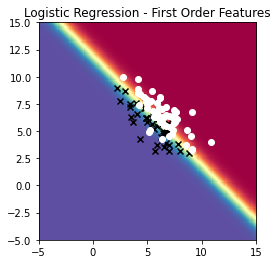

In [ ]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

lr_fig, lr_ax = plt.subplots()

maxs = 15
mins = -5
 
X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

predictions = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([1, X_dim1[i, j], X_dim2[i, j]]) # X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2
    outputs = lr_model(x_t).double()
    predictions[i, j] = outputs[0]
    

lr_ax.imshow(predictions, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

lr_ax.scatter(pos[:,0], pos[:,1], marker="x", color="black")
lr_ax.scatter(neg[:,0], neg[:,1], marker="o", color="white")
lr_ax.set_title("Logistic Regression - First Order Features")

In [ ]:
iw_model = binaryLRTrain(x_1_b, y_1, torch.Tensor(d_t / d_s).unsqueeze(1))

loss, preds, acc = binaryLRTest(iw_model, x_2_b, y_2)
print(f"Target Loss: {loss}. Accuracy: {acc}")

Loss at step 0: 15.752140998840332
Loss at step 1000: 0.6052042245864868
Loss at step 2000: 0.5760133266448975
Loss at step 3000: 0.5577603578567505
Loss at step 4000: 0.5426439642906189
Loss at step 5000: 0.5311148762702942
Loss at step 6000: 0.5234957933425903
Loss at step 7000: 0.5192238688468933
Loss at step 8000: 0.5173240900039673
Loss at step 9000: 0.5167459845542908
Target Loss: 0.5480843186378479. Accuracy: 0.8799999952316284


Text(0.5, 1.0, 'Importance Weighting - First Order Features')

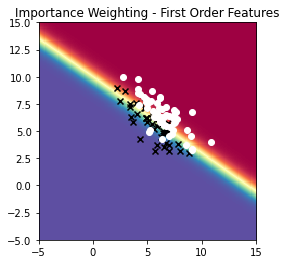

In [ ]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

lr_fig, lr_ax = plt.subplots()

maxs = 15
mins = -5
 
X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

predictions = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([1, X_dim1[i, j], X_dim2[i, j]]) 
    outputs = iw_model(x_t).double()
    predictions[i, j] = outputs[0]
    

lr_ax.imshow(predictions, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

lr_ax.scatter(pos[:,0], pos[:,1], marker="x", color="black")
lr_ax.scatter(neg[:,0], neg[:,1], marker="o", color="white")
lr_ax.set_title("Importance Weighting - First Order Features")

#### Second-Order Features

In [ ]:
lr_model = binaryLRTrain(x_1_sec_b / 10, y_1, torch.ones((len(x_1), 1)))
loss, preds, acc = binaryLRTest(lr_model, x_2_sec_b / 10, y_2)
print(f"Target Loss: {loss}")

Loss at step 0: 15.335493087768555
Loss at step 1000: 0.6060230135917664
Loss at step 2000: 0.5248032212257385
Loss at step 3000: 0.46038147807121277
Loss at step 4000: 0.4186622202396393
Loss at step 5000: 0.3944123089313507
Loss at step 6000: 0.381745845079422
Loss at step 7000: 0.3761238753795624
Loss at step 8000: 0.3741365075111389
Loss at step 9000: 0.373421847820282
Target Loss: 0.6777912974357605


Text(0.5, 1.0, 'Logistic Regression - Second Order Features')

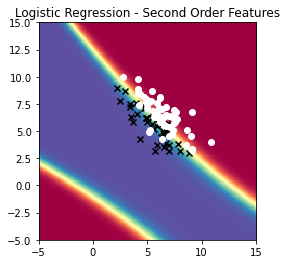

In [ ]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots()

maxs = 15
mins = -5
 
X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

predictions = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([1, X_dim1[i, j], X_dim2[i, j], X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2]) / 10
    outputs = lr_model(x_t).double()
    predictions[i, j] = outputs[0]
    

ax.imshow(predictions, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

ax.scatter(pos[:,0], pos[:,1], marker="x", color="black")
ax.scatter(neg[:,0], neg[:,1], marker="o", color="white")
ax.set_title("Logistic Regression - Second Order Features")

In [ ]:
iw_model = binaryLRTrain(x_1_sec_b, y_1, torch.Tensor(d_t / d_s).unsqueeze(1), max_itr=80000, lr = 0.05)

Loss at step 0: 44.515289306640625
Loss at step 1000: 0.5070279240608215
Loss at step 2000: 0.5045703053474426
Loss at step 3000: 0.5028612017631531
Loss at step 4000: 0.5006560683250427
Loss at step 5000: 0.49862387776374817
Loss at step 6000: 0.5021982789039612
Loss at step 7000: 0.4958568215370178
Loss at step 8000: 0.4948667287826538
Loss at step 9000: 0.4940132796764374
Loss at step 10000: 0.498414546251297
Loss at step 11000: 0.49254298210144043
Loss at step 12000: 0.4996485114097595
Loss at step 13000: 0.49125975370407104
Loss at step 14000: 0.49066147208213806
Loss at step 15000: 0.4900892376899719
Loss at step 16000: 0.4895184338092804
Loss at step 17000: 0.4890538454055786
Loss at step 18000: 0.4884816110134125
Loss at step 19000: 0.48803871870040894
Loss at step 20000: 0.48741477727890015
Loss at step 21000: 0.48704564571380615
Loss at step 22000: 0.4864296615123749
Loss at step 23000: 0.4859582185745239
Loss at step 24000: 0.48789137601852417
Loss at step 25000: 0.485177546

Text(0.5, 1.0, 'Importance Reweighting - Second Order Features')

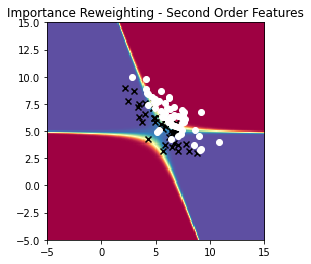

In [ ]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots()

maxs = 15
mins = -5
 
X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

predictions = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([1, X_dim1[i, j], X_dim2[i, j], X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2])
    outputs = iw_model(x_t).double()
    predictions[i, j] = outputs[0]
    

ax.imshow(predictions, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

ax.scatter(pos[:,0], pos[:,1], marker="x", color="black")
ax.scatter(neg[:,0], neg[:,1], marker="o", color="white")
ax.set_title("Importance Reweighting - Second Order Features")

### Robust Bias-Aware (RBA) 


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam

class RBAClassifier(nn.Module):
    def __init__(self, in_features = 2, out_features = 1):
      super(RBAClassifier, self).__init__()
      self.layer1 = nn.Linear(in_features, out_features, bias = True)

    def forward(self, input):
      return self.layer1(input)

In [ ]:
class RBAGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, output, prob, y):
        ctx.save_for_backward(output, prob, y)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, prob, y = ctx.saved_tensors
        grad_temp = grad_output.clone()
        grad_input = grad_temp * (prob - y)
        return grad_input, None, None

"""class RBAGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, theta, output, prob, y):
        ctx.save_for_backward(theta, output, prob, y)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        theta, output, prob, y = ctx.saved_tensors
        grad_temp = grad_output.clone()
        grad_input = grad_temp * (prob - y)
        return grad_input, None, None, None"""

'class RBAGrad(torch.autograd.Function):\n    @staticmethod\n    def forward(ctx, theta, output, prob, y):\n        ctx.save_for_backward(theta, output, prob, y)\n        return output\n\n    @staticmethod\n    def backward(ctx, grad_output):\n        theta, output, prob, y = ctx.saved_tensors\n        grad_temp = grad_output.clone()\n        grad_input = grad_temp * (prob - y)\n        return grad_input, None, None, None'

In [ ]:
def binaryRBATrain(X_s, y_s, r_st, max_itr = 10000, lr = 0.01):

  rba_model = RBAClassifier(in_features = X_s.shape[1])
  loss_fn = nn.BCELoss() 
  optimizer = torch.optim.Adam(rba_model.parameters(), lr = lr)

  for param in rba_model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

  rba_model.train()

  # convert labels from -1, 1 to 0, 1
  if -1 in y_s:
    y_s = torch.FloatTensor(np.where(y_s == 1, 1, 0))

  n_row, _ = X_s.shape

  for i in range(max_itr):  # loop over the dataset multiple times
      running_loss = 0.0
    
      optimizer.zero_grad()
      
      outputs = rba_model.forward(X_s)
      output_last = RBAGrad.apply(outputs, torch.sigmoid(outputs * r_st), y_s)
      output_last.backward(torch.ones(output_last.shape))

      # adjust parameters based on the calculated gradients
      optimizer.step()
      
      loss = loss_fn(torch.sigmoid(outputs.squeeze()), y_s.squeeze())
      if i % 1000 == 0:
        print(f"Loss at step {i}: {float(loss.data)}")


  return rba_model

In [ ]:
def binaryRBATest(model, X_t, y_t, r_st):
  n_row, _ = X_t.shape
  
  model.eval()

  if -1 in y_t:
    y_t = torch.FloatTensor(np.where(y_t == 1, 1, 0))

  loss_fn = nn.BCELoss() 

  outputs = model(X_t)
  preds = torch.sigmoid(outputs * r_st)
  loss = loss_fn(preds.squeeze(), y_t.squeeze())
  acc = torch.sum(torch.round(preds) == y_t) / n_row
  return loss, preds, acc

#### First-Order Features

In [ ]:
r_st = torch.Tensor(d_s / d_t).unsqueeze(1)
rba_model = binaryRBATrain(x_1, y_1, r_st, lr = 0.01) # torch.Tensor(d_s / d_t).unsqueeze(1)

loss, preds, acc = binaryRBATest(rba_model, x_2, y_2, r_st)
print(f"Target Loss: {loss}. Accuracy: {acc}")

Loss at step 0: 8.603636741638184
Loss at step 1000: 0.6452558040618896
Loss at step 2000: 0.5796209573745728
Loss at step 3000: 0.5176428556442261
Loss at step 4000: 0.46658870577812195
Loss at step 5000: 0.4302445352077484
Loss at step 6000: 0.40805840492248535
Loss at step 7000: 0.39614829421043396
Loss at step 8000: 0.3908524215221405
Loss at step 9000: 0.3883082866668701
Target Loss: 2.6679651737213135. Accuracy: 0.8799999952316284


Text(0.5, 1.0, 'RBA - First Order Features')

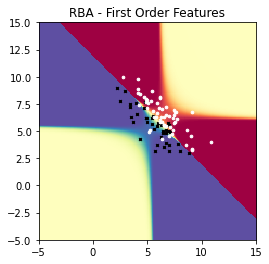

In [ ]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

maxs = 15
mins = -5

X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

prediction = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([X_dim1[i, j], X_dim2[i, j]])
    outputs = torch.sigmoid(rba_model(x_t) * mvn_s.pdf(x_t) / mvn_t.pdf(x_t))
    prediction[i, j] = outputs[0]

plt.imshow(prediction, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

plt.scatter(pos[:,0], pos[:,1], marker="x", color="black", s = 7)
plt.scatter(neg[:,0], neg[:,1], marker="o", color="white", s = 7)
plt.title("RBA - First Order Features")

#### Second-Order Features

In [ ]:
r_st = torch.Tensor(d_s / d_t).unsqueeze(1)
rba_model = binaryRBATrain(x_1_sec, y_1, r_st) 

loss, preds, acc = binaryRBATest(rba_model, x_2_sec, y_2, r_st)
print(f"Target Loss: {loss}. Accuracy: {acc}")

Loss at step 0: 56.0
Loss at step 1000: 0.46627509593963623
Loss at step 2000: 0.399257630109787
Loss at step 3000: 0.38316506147384644
Loss at step 4000: 0.3797203004360199
Loss at step 5000: 0.378834068775177
Loss at step 6000: 0.3783676028251648
Loss at step 7000: 0.377840131521225
Loss at step 8000: 0.37701043486595154
Loss at step 9000: 0.37603163719177246
Target Loss: 2.8064165115356445. Accuracy: 0.8899999856948853


Text(0.5, 1.0, 'RBA - Second Order Features')

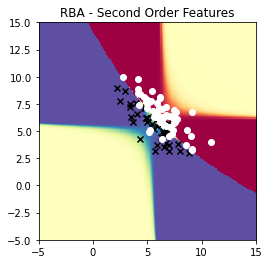

In [ ]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

maxs = 15
mins = -5

X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

prediction = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([X_dim1[i, j], X_dim2[i, j], X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2])
    outputs = torch.sigmoid(rba_model(x_t) * mvn_s.pdf(x_t[:2]) / mvn_t.pdf(x_t[:2]))
    prediction[i, j] = outputs[0]

plt.imshow(prediction, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

plt.scatter(pos[:,0], pos[:,1], marker="x", color="black")
plt.scatter(neg[:,0], neg[:,1], marker="o", color="white")
plt.title("RBA - Second Order Features")

## MultiClass Classification

### Load Data

In [ ]:
import scipy.io
import numpy as np
import os

folder_path = '/content' # TODO Change this

iris_train = scipy.io.loadmat(os.path.join(folder_path, 'iris_train.mat'))['iris_train']
iris_test = scipy.io.loadmat(os.path.join(folder_path, 'iris_test.mat'))['iris_test']

X_s = iris_train[:,0:-1]
y_s = iris_train[:, -1]
X_t = iris_test[:,0:-1]
y_t = iris_test[:,-1]

In [ ]:
from sklearn import preprocessing
import torch

lb = preprocessing.LabelBinarizer()
lb.fit(y_s)

Y_s = lb.transform(y_s)
Y_t = lb.transform(y_t)

X_s = torch.FloatTensor(X_s).detach()
X_t = torch.FloatTensor(X_t).detach()
Y_s = torch.FloatTensor(Y_s)
Y_t = torch.FloatTensor(Y_t)

n_row, n_col = X_s.shape

In [ ]:
X_s_b = torch.cat((torch.ones((X_s.shape[0], 1)), X_s), dim = 1)
X_t_b = torch.cat((torch.ones((X_t.shape[0], 1)), X_t), dim = 1)

In [ ]:
def binaryRobustTrain(X_s, y_s, r_st, r_ts, lamb = 0.001, lr = 1, max_itr = 10000, min_gradient = 0.0001):
  n_row, n_col = X_s.shape

  # F : Features 
  F = np.concatenate((np.ones((n_row, 1)), X_s), axis=1) 

  # F_g : Features reweighted under target / source density
  F_g = F * np.tile(r_ts, n_col + 1)

  # P : predictions
  P = np.zeros((n_row, 1)) 

  # S_g : velocity term in Adam? 
  S_g = np.ones((n_col + 1, 1)) * 1e-8

  # theta : Weights
  theta = np.ones((n_col + 1, 1)) 

  # l_0 : momentum
  l_0 = 0

  # l_1 : 
  l_1 = (1 + (1 + (4 * l_0 ** 2)) ** 0.5) / 2
  delta_1 = 0

  t = 1
  while True:
    t = t + 1

    decay = np.sqrt(1000 / (1000 + t))

    l_2 = (1 + (1 + (4 * l_1 ** 2)) ** 0.5) / 2
    l_3 = (1 - l_1) / l_2

    for i in range(n_row):
      W = r_st[i]

      # temp is evaluated so that you want your prediction theta * features to be as close to the real y_s. 
      # if prediction matches real value, then temp will be 1 for both classes
      temp =  (np.dot(np.transpose(theta), np.transpose(F[i, :])) * y_s[i] * W)[0]   # why multiply by y_s here when you aren't multiplying by y_s in multiClassTrain? 
      temp_max = max(temp, -1 * temp)  
      temp_min = min(temp, -1 * temp)

      # P[i] : estimator that is bounded between 0 and 1? 
      # According to the paper, this is Theorem 2 or Part 5 I believe? 
      P[i] = np.exp(temp - temp_max - np.log(1 + np.exp(temp_min - temp_max)))

    # G : Gradient 
    G = np.transpose(np.dot(np.transpose(P * y_s), F_g)) - np.transpose(np.dot(np.transpose(y_s), F_g)) + 2 * lamb * theta
    if np.linalg.norm(G) < min_gradient:
      print('Optimization stops by reaching minimum gradient.')
      break

    # updating velocity 
    S_g = S_g + G ** 2

    # delta_2 : 
    delta_2 = theta - decay * lr * G / np.sqrt(S_g) 
    theta = (1 - l_3) * delta_2 + l_3 * delta_1
    delta_1 = delta_2
    l_1 = l_2

    if t > max_itr:
      print("Optimizination stops by reaching maximum iteration")
      break

  return theta

In [ ]:
def binaryRobustTest(theta, X_t, y_t, r_st):
  n_row, _ = X_t.shape

  F = np.concatenate((np.ones((n_row, 1)), X_t), axis=1) 

  P = np.zeros((n_row, 1))
  logloss = 0
  prediction = np.zeros((n_row, 2))
  for i in range(n_row):
    W = r_st[i]
    temp =  (np.dot(np.transpose(theta), np.transpose(F[i, :])) * y_t[i] * W)[0]      
    temp_max = max(temp, -1 * temp)
    temp_min = min(temp, -1 * temp)
    P[i] = np.exp(temp - temp_max - np.log(1 + np.exp(temp_min - temp_max)))
    logloss = logloss - np.log(P[i])

    if y_t[i] == 1:
      prediction[i] = [P[i], 1 - P[i]]
    else:
      prediction[i] = [1 - P[i], P[i]]

  logloss = logloss / n_row / 0.6931
  return logloss, prediction

def computeAcc(pred, y):
  n_row, n_class = pred.shape
  
  max_ind = np.argmax(pred, axis = 1)

  summ = 0

  if n_class == 2:
    for i in range(n_row):
      if max_ind[i] == 1 and y[i] == -1:
        summ += 1
      elif max_ind[i] == 0 and y[i] == 1:
        summ += 1
  else:
    summ = sum(np.argmax(pred, axis = 1) == y_t - 1)

  return summ / n_row


In [ ]:
def LRDensityEstimation(X_s, X_t, lambdas = [0.0625, 1, 16]):

  np.random.seed(10) # seed set in matlab code as well for verification

  ns_row, _ = X_s.shape
  nt_row, _ = X_t.shape

  inda_s = np.arange(ns_row)
  inda_t = np.arange(nt_row)

  nv_s = int(np.floor(0.2 * ns_row))
  nv_t = int(np.floor(0.2 * nt_row))

  indv_s = np.array([92, 3, 74, 87, 57, 26, 23, 85, 19, 10, 75, 103, 1, 54, 111, 64, 116, 30, 118, 71, 105, 14, 36]) - 1 # indv_s = np.random.permutation(ns_row)[:nv_s] 

  indv_t = np.array([22, 14, 31, 18, 15, 29]) - 1 # np.random.permutation(nt_row)[:nv_t]

  indt_s = np.setdiff1d(inda_s, indv_s)
  
  indt_t = np.setdiff1d(inda_t, indv_t)

  X_train = np.concatenate((X_s[indt_s, :], X_t[indt_t, :]))
  X_valid = np.concatenate((X_s[indv_s, :], X_t[indv_t, :]))
  
  y_train = np.concatenate((np.ones((ns_row - nv_s, 1)), -1 * np.ones((nt_row - nv_t, 1)) ))
  y_valid = np.concatenate((np.ones((nv_s, 1)), -1 * np.ones((nv_t, 1)) ))

  rt_st = np.ones((ns_row + nt_row - nv_s - nv_t, 1))
  rv_st = np.ones((nv_s + nv_t, 1))
  
  logloss = np.zeros((len(lambdas), 1))
  for i, lamb in enumerate(lambdas):
    theta = binaryRobustTrain(X_train, y_train, rt_st, rt_st, lamb=lamb,min_gradient=0.1)
    _, pred = binaryRobustTest(theta, X_valid, y_valid, rv_st )
    logloss[i] = (-sum(np.log(pred[:nv_s, 0])) - sum(np.log(pred[nv_s: nv_s + nv_t, 1]))) / (nv_s + nv_t) / 0.6931

  ind_min = np.argmin(logloss)

  X_train = np.concatenate((X_s, X_t))
  y_train = np.concatenate((np.ones((ns_row, 1)), -1 * np.ones((nt_row, 1)) ))
  r_st = np.ones((ns_row + nt_row, 1))

  theta = binaryRobustTrain(X_train, y_train, r_st, r_st, lambdas[ind_min])
  _, pred = binaryRobustTest(theta, X_train, y_train, r_st)

  d_ss = pred[:ns_row, 0]
  d_st = pred[:ns_row, 1]

  d_ts = pred[ns_row:, 0]
  d_tt = pred[ns_row:, 1]

  print("Finish Density Estimation")

  return d_ss, d_st, d_ts, d_tt

In [ ]:
d_ss, d_st, d_ts, d_tt = LRDensityEstimation(X_s, X_t, [0.1, 1, 10])

Optimization stops by reaching minimum gradient.
Optimization stops by reaching minimum gradient.
Optimization stops by reaching minimum gradient.
Optimization stops by reaching minimum gradient.
Finish Density Estimation


### Logistic Regression (LR) + Importance Weighting (IW)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

class MultiClassLR(nn.Module):
    def __init__(self, in_features = 4, out_features = 3):
      super(MultiClassLR, self).__init__()
      
      self.layer1 = nn.Linear(in_features, out_features, bias = False)
      self.activation1 = nn.Softmax(dim=1)

    def forward(self, input):
      return self.activation1(self.layer1(input))

In [ ]:
from torch.optim import Adam

def multiLRTrain(X_s, y_s, r_ts, max_itr = 10000, lr = 0.01, weight_decay = 0):

  n_row, n_col = X_s.shape
  
  model = MultiClassLR(in_features = n_col)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

  model.train()

  for param in model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

  F = X_s * r_ts.repeat(1, n_col)
  
  for i in range(max_itr): 
    optimizer.zero_grad()
    
    outputs = model(F) 

    loss = loss_fn(outputs, y_s)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
      print(f"Loss at step {i}: {float(loss.data)}")
  
  return model

In [ ]:
def multiLRTest(model, X_t, y_t):

  loss_fn = nn.CrossEntropyLoss()
  outputs = model(X_t)

  loss = loss_fn(outputs, y_t)
  preds = outputs
  acc = torch.sum(torch.argmax(model(X_t), dim = 1) == torch.argmax(Y_t, dim = 1)) / len(Y_t)
  return loss, preds, acc

In [ ]:
multi_lr_model = multiLRTrain(X_s_b, Y_s, torch.ones(n_row, 1), lr = 0.01)

Loss at step 0: 1.0986124277114868
Loss at step 1000: 0.6025437712669373
Loss at step 2000: 0.5869957804679871
Loss at step 3000: 0.5815357565879822
Loss at step 4000: 0.5785336494445801
Loss at step 5000: 0.5764588713645935
Loss at step 6000: 0.5748035907745361
Loss at step 7000: 0.5733606815338135
Loss at step 8000: 0.5720071792602539
Loss at step 9000: 0.5706669688224792


In [ ]:
loss, preds, acc = multiLRTest(multi_lr_model, X_t_b, Y_t)
print(f"Target Loss: {loss}. Accuracy: {acc}")

Target Loss: 0.5864711999893188. Accuracy: 0.96875


In [ ]:
r_ts = torch.FloatTensor(d_st / d_ss).unsqueeze(1).detach()

multi_iw_model = multiLRTrain(X_s_b, Y_s, r_ts, lr = 1)

Loss at step 0: 1.0986124277114868
Loss at step 1000: 0.7408914566040039
Loss at step 2000: 0.6954430341720581
Loss at step 3000: 0.6695226430892944
Loss at step 4000: 0.6514200568199158
Loss at step 5000: 0.6378334164619446
Loss at step 6000: 0.6271067261695862
Loss at step 7000: 0.6180447340011597
Loss at step 8000: 0.6096295714378357
Loss at step 9000: 0.6015253663063049


In [ ]:
loss, preds, acc = multiLRTest(multi_iw_model, X_t_b, Y_t)
print(f"Target Loss: {loss}. Accuracy: {acc}")

Target Loss: 0.5826946496963501. Accuracy: 0.96875


### Robust Bias-Aware (RBA) 

In [ ]:
def multiRBATrain(X_s, y_s, r_st, max_itr = 10000, lr = 0.01):

  rba_model = RBAClassifier(in_features = X_s.shape[1], out_features = y_s.shape[1])
  loss_fn = nn.CrossEntropyLoss() 
  optimizer = torch.optim.Adam(rba_model.parameters(), lr = lr)

  for param in rba_model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

  rba_model.train()

  # convert labels from -1, 1 to 0, 1
  if -1 in y_s:
    y_s = torch.FloatTensor(np.where(y_s == 1, 1, 0))

  n_row, _ = X_s.shape

  for i in range(max_itr):  # loop over the dataset multiple times
      running_loss = 0.0
    
      optimizer.zero_grad()
      
      outputs = rba_model.forward(X_s)
      output_last = RBAGrad.apply(outputs, torch.sigmoid(outputs * r_st), y_s)
      output_last.backward(torch.ones(output_last.shape))

      # adjust parameters based on the calculated gradients
      optimizer.step()
      
      loss = loss_fn(torch.sigmoid(outputs.squeeze()), y_s.squeeze())
      if i % 1000 == 0:
        print(f"Loss at step {i}: {float(loss.data)}")


  return rba_model

In [ ]:
def multiRBATest(model, X_t, y_t, r_st):
  model.eval()

  loss_fn = nn.CrossEntropyLoss()
  outputs = model(X_t)
  
  preds = torch.sigmoid(outputs * r_st)

  loss = loss_fn(preds, y_t)
  acc = torch.sum(torch.argmax(preds, dim = 1) == torch.argmax(Y_t, dim = 1)) / len(Y_t)
  return loss, preds, acc

In [ ]:
rba_model = multiRBATrain(X_s, Y_s, torch.Tensor(d_ss / d_st).unsqueeze(1), max_itr=40000)

Loss at step 0: 1.0986124277114868
Loss at step 1000: 0.9644071459770203
Loss at step 2000: 0.9133692383766174
Loss at step 3000: 0.8844454884529114
Loss at step 4000: 0.8660852313041687
Loss at step 5000: 0.8542410135269165
Loss at step 6000: 0.8465876579284668
Loss at step 7000: 0.8411120176315308
Loss at step 8000: 0.8362189531326294
Loss at step 9000: 0.8300734758377075
Loss at step 10000: 0.825667142868042
Loss at step 11000: 0.8229186534881592
Loss at step 12000: 0.8212841749191284
Loss at step 13000: 0.8202203512191772
Loss at step 14000: 0.8195014595985413
Loss at step 15000: 0.8190363049507141
Loss at step 16000: 0.8187390565872192
Loss at step 17000: 0.81852787733078
Loss at step 18000: 0.8184016346931458
Loss at step 19000: 0.8183199763298035
Loss at step 20000: 0.8182492852210999
Loss at step 21000: 0.8182048201560974
Loss at step 22000: 0.8181774616241455
Loss at step 23000: 0.8180627226829529
Loss at step 24000: 0.8180716633796692
Loss at step 25000: 0.8180766105651855
Lo

In [ ]:
loss, preds, acc = multiRBATest(rba_model, X_t, Y_t, torch.Tensor(d_ts / d_tt).unsqueeze(1))
print(f"Target Loss: {loss}. Accuracy: {acc}")

Target Loss: 0.7247159481048584. Accuracy: 0.96875


In [ ]:
torch.argmax(preds, dim = 1) == torch.argmax(Y_t, dim = 1)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False])

# New Section